In [1]:
from itertools import islice

import torch
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt

import data_util
from models.finetuned_resnet import FinetunedResnet
import constants

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)
np.set_printoptions(suppress=True)


def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [3]:
dataloaders = data_util.get_dataloaders(batch_size=1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [36]:
def pull_maps(dataloader, model_path, model_class = models.resnet18):
    class_names = dataloader.dataset.dataset.classes
    negative_class = class_names.index('negatives')
    
    resnet = FinetunedResnet(model_class, constants.NUM_CLASSES, device)
    resnet.model.load_state_dict(torch.load(model_path))
    for img, label in islice(dataloader, 2):
        img_rgb = img.squeeze()
        print(img.shape, class_names[label], label)
        std = torch.Tensor([.229, .224, .225]).reshape(3,1,1)
        mean = torch.Tensor([.485, .456, .406]).reshape(3,1,1)
        rescaled_image = img_rgb * std + mean
        show(rescaled_image)
        plt.show()
        
        grid_activations = resnet.model.forward(img, True).detach()
        per_pixel_class_probs = torch.nn.Softmax(dim=1)(grid_activations.squeeze())
        
        per_pixel_prob_weed = 1. - per_pixel_class_probs[negative_class,:,:]
        print(per_pixel_prob_weed.shape)
        plt.imshow(per_pixel_prob_weed, cmap='Reds')
        plt.show()
        
        per_pixel_prob_correct = per_pixel_class_probs[int(label),:,:]
        print(per_pixel_prob_correct.shape)
        plt.imshow(per_pixel_prob_correct, cmap='hot')
        plt.show()
        

torch.Size([1, 3, 224, 224]) negatives tensor([2])


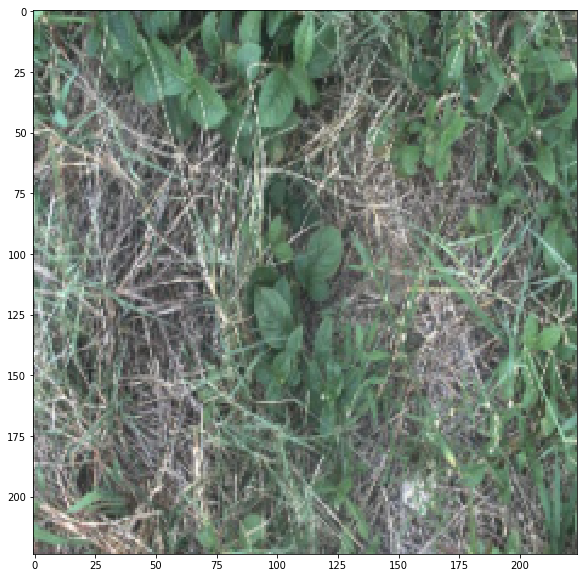

torch.Size([7, 7])


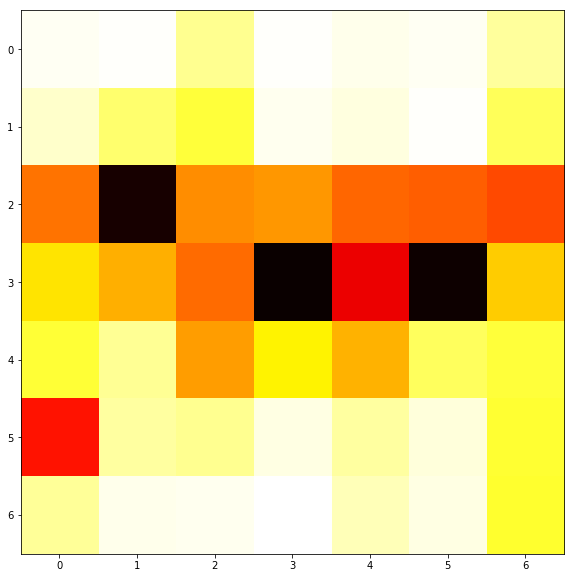

torch.Size([7, 7])


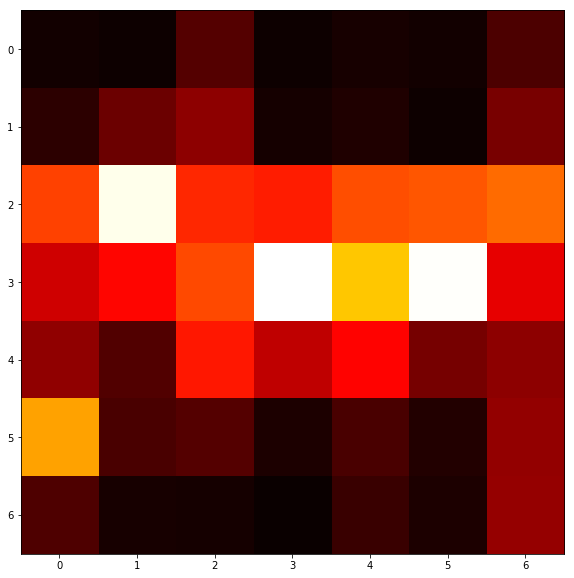

torch.Size([1, 3, 224, 224]) negatives tensor([2])


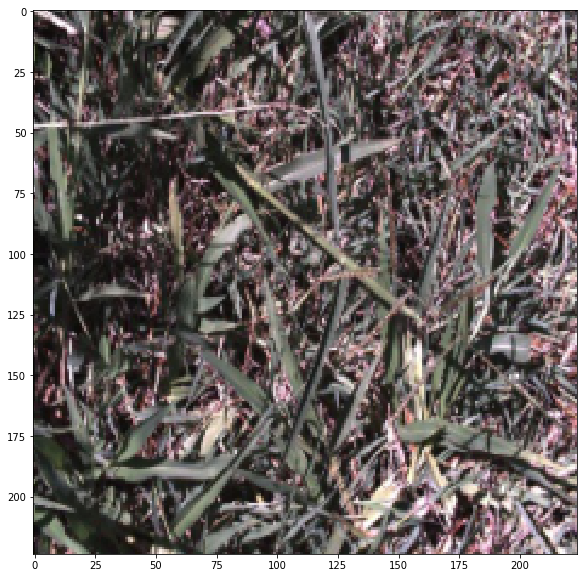

torch.Size([7, 7])


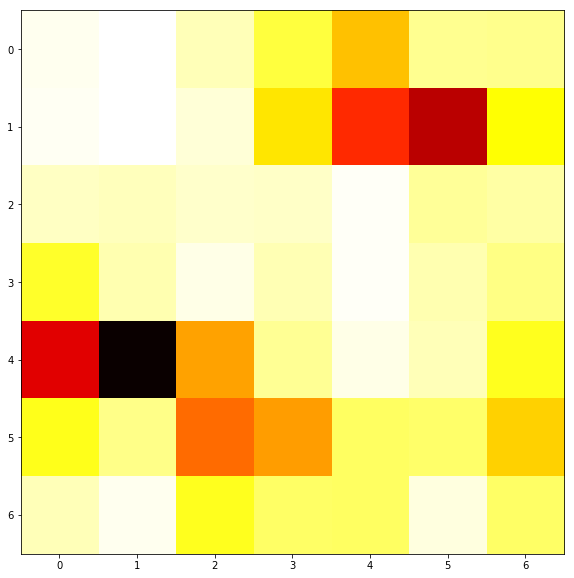

torch.Size([7, 7])


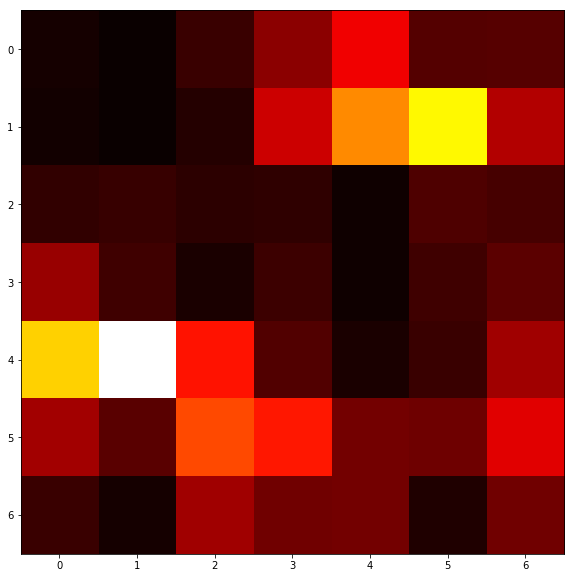

In [37]:
pull_maps(dataloaders['train'], 'logs/2019-06-02_13-41-22/model_dict_9.pth')